In [69]:
import os
import json
import sys
import glob
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning as L
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from data_module.data_module import ALDataModule_v1
from model.classifier_model import Classifier1DMaxPoolBNModel, Classifier1D
from utils.model_utils import unwrap_model

from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict

In [50]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("-tl", "--train_limit_data", type=int, default=1000,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=8,
                    help=f"Number of class num use to train")

parser.add_argument("--target_class", type=int, default=3,
                    help=f"Number of class num use to train")

parser.add_argument("--target_class_data_num", type=int, default=10,
                    help=f"Number of data for the target class to train")

parser.add_argument("-m", "--model_name", type=str, default="4cnn_64",
                    help=f"Config name of model used for training")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

parser.add_argument("--patience", type=int, default=200,
                    help=f"Early stopping patience")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [56]:
def create_data_module():
    L.seed_everything(42)
    print("args.target_class, args.target_class_data_num", args.target_class, args.target_class_data_num)
    data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")
    data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
    train_data, train_label = data_module.reduce_one_class_number(data_module.train_data, data_module.train_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
    val_data, val_label = data_module.reduce_one_class_number(data_module.val_data, data_module.val_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
    test_data, test_label = data_module.reduce_one_class_number(data_module.test_data, data_module.test_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
    
    data_module.set_train_val_test_pred_data(
        train_data = train_data,
        train_label = train_label,
        val_data = val_data,
        val_label = val_label,
        test_data = test_data,
        test_label = test_label,
        pred_data = test_data,
    )
    
    print(np.unique(data_module.train_label, return_counts=True))
    print(np.unique(data_module.val_label, return_counts=True))
    print(np.unique(data_module.test_label, return_counts=True))

    return data_module

In [57]:
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

log_save_dir = "lightning_logs"
log_save_name = "20_AL_train_unbalance/{}-{}-{}-{}-{}-{}-{}"

In [63]:
def get_acc_from_save_folder(save_model_folder):
    save_model_dir = os.path.join(log_save_dir, save_model_folder)
    
    weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]

    net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight)
    data_module = create_data_module()

    trainer = L.Trainer()
    trainer.test(model=net, datamodule=data_module, verbose=False)
    test_acc = trainer.logged_metrics["test_acc"]

    # Calculate target class TPR
    output = trainer.predict(model=net, datamodule=data_module)
    pred = torch.argmax(torch.concat(output), dim=1)
    gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))
    
    gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))
    target_class_idx = gt_ravel == args.target_class - 1
    
    pred_ravel = pred.numpy()
    target_class_pred_idx = pred_ravel == args.target_class - 1
    target_class_tpr = np.sum(target_class_pred_idx&target_class_idx) / np.sum(target_class_idx)

    print(target_class_tpr)
    print("Error number", (gt_ravel!=pred_ravel).sum())

    return test_acc, target_class_tpr

In [12]:
acc_result_dict = defaultdict(list)
save_model_folder_dict = defaultdict(list)
target_class_tpr_result_dict = defaultdict(list)

for args.target_class in [3, 4, 5]:
    for args.target_class_data_num in "10 20 30 50 100".split(" "):
        args.target_class_data_num = int(args.target_class_data_num)
        for args.random_seed in "42 64".split(" "):
            for args.patience in "200 300 400".split(" "):
                save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.target_class, args.target_class_data_num, args.patience, args.random_seed)
                print("RUNNING FOR", save_model_folder)
                test_acc, target_class_tpr = get_acc_from_save_folder(save_model_folder)
                print("test_acc, target_class_tpr", test_acc, target_class_tpr)
                # test_acc = random.random()
                acc_result_dict[(args.target_class, args.target_class_data_num)].append(test_acc.item())
                save_model_folder_dict[(args.target_class, args.target_class_data_num)].append(save_model_folder)
                target_class_tpr_result_dict[(args.target_class, args.target_class_data_num)].append(target_class_tpr)


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 120.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 150.40it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 155.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 176.67it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 101.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 121.53it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 142.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 179.41it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 144.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 126.60it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
reduce_one_class_number target_class= 3 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   10, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   10, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 183.89it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 150.42it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 188.46it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 104.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 170.15it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 141.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.57it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 102.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 154.38it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 145.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 183.53it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
reduce_one_class_number target_class= 3 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   20, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   20, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 142.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 128.25it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 119.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 137.80it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 138.80it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 179.49it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 150.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 122.93it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 164.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 179.98it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 109.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 163.93it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
reduce_one_class_number target_class= 3 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   30, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   30, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 134.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 162.11it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 113.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 127.92it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 111.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 161.54it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 180.32it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 114.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 134.18it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 122.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 176.45it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
reduce_one_class_number target_class= 3 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,   50, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,   50, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 150.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 137.23it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 95.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 136.99it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 149.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 140.35it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 147.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 142.54it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 147.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 131.11it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 147.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 126.11it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
reduce_one_class_number target_class= 3 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  100, 1000, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  100, 1000, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 141.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 181.71it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   10, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 125.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 115.55it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   10, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 123.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 135.09it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   10, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 103.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 162.31it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   10, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 155.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 189.87it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   10, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 159.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 177.41it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   10, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 114.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 138.69it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   20, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 148.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 176.58it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   20, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 109.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 184.60it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   20, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 145.31it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 142.97it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   20, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 102.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 165.86it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   20, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 149.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 177.75it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
reduce_one_class_number target_class= 4 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   20, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   20, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 148.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 172.55it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   30, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 155.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 147.02it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   30, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 118.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 144.89it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   30, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 110.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 180.96it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   30, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 106.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 165.26it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   30, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 111.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 141.94it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
reduce_one_class_number target_class= 4 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   30, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   30, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 157.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 182.74it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   50, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 107.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 181.51it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   50, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 131.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.67it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   50, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 149.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 139.20it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   50, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 86.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 117.27it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   50, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 146.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 171.06it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
reduce_one_class_number target_class= 4 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   50, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   50, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 103.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 126.48it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,  100, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 110.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 182.65it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,  100, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 114.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 171.82it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,  100, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 105.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 142.07it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,  100, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 140.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 165.50it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,  100, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 112.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 191.39it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
reduce_one_class_number target_class= 4 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,  100, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,  100, 1000, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 162.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 191.18it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   10, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 127.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 133.14it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   10, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 102.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 135.55it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   10, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 150.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 110.05it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   10, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 108.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 173.53it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   10, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 146.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 131.86it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
reduce_one_class_number target_class= 5 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   10, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   10, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 130.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 177.12it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   20, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 90.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 167.13it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   20, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 127.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 139.28it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   20, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 145.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 135.02it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   20, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 138.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 159.53it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   20, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 146.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 128.06it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
reduce_one_class_number target_class= 5 target_class_data_num= 20
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   20, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   20, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 105.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 185.28it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   30, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 119.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 157.96it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   30, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 148.70it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 191.12it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   30, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 174.19it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   30, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 158.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 140.12it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   30, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 142.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 144.51it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
reduce_one_class_number target_class= 5 target_class_data_num= 30
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   30, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   30, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 148.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 189.57it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   50, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 115.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 171.32it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   50, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 112.08it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 154.31it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   50, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 142.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 187.71it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   50, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 113.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 186.22it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   50, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 112.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 155.24it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
reduce_one_class_number target_class= 5 target_class_data_num= 50
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,   50, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,   50, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 112.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 172.10it/s]

Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,  100, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 98.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 135.09it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,  100, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.42it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 141.15it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,  100, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 148.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 183.23it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,  100, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 141.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 148.33it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,  100, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 144.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 183.87it/s]


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
reduce_one_class_number target_class= 5 target_class_data_num= 100
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000,  100, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000,  100, 1000, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 152.13it/s]


In [7]:
for args.target_class in [3, 4, 5]:
    for args.target_class_data_num in "10 20 30 50 100".split(" "):
        args.target_class_data_num = int(args.target_class_data_num)
        
        print("save_model_folder_dict", save_model_folder_dict[(args.target_class, args.target_class_data_num)])
        print("acc_result_dict", acc_result_dict[(args.target_class, args.target_class_data_num)])
        print("target_class_tpr_result_dict", target_class_tpr_result_dict[(args.target_class, args.target_class_data_num)])

        print()


20_AL_train_unbalance/4cnn_64-8-1000-3-10-300-64 20_AL_train_unbalance/4cnn_64-8-1000-3-20-300-42 20_AL_train_unbalance/4cnn_64-8-1000-3-30-400-64 20_AL_train_unbalance/4cnn_64-8-1000-3-50-200-64 20_AL_train_unbalance/4cnn_64-8-1000-3-100-400-42 20_AL_train_unbalance/4cnn_64-8-1000-4-10-400-64 20_AL_train_unbalance/4cnn_64-8-1000-4-20-300-64 20_AL_train_unbalance/4cnn_64-8-1000-4-30-200-64 20_AL_train_unbalance/4cnn_64-8-1000-4-50-400-42 20_AL_train_unbalance/4cnn_64-8-1000-4-100-300-64 20_AL_train_unbalance/4cnn_64-8-1000-5-10-400-64 20_AL_train_unbalance/4cnn_64-8-1000-5-20-200-42 20_AL_train_unbalance/4cnn_64-8-1000-5-30-300-64 20_AL_train_unbalance/4cnn_64-8-1000-5-50-400-42 20_AL_train_unbalance/4cnn_64-8-1000-5-100-300-64 

In [ ]:
for args.target_class in [3, 4, 5]:
    for args.target_class_data_num in "10 20 30 50 100".split(" "):
        args.target_class_data_num = int(args.target_class_data_num)
        
        argmax_idx = np.argmax(acc_result_dict[(args.target_class, args.target_class_data_num)])
        print(save_model_folder_dict[(args.target_class, args.target_class_data_num)][argmax_idx], end=" ")

In [96]:

# a = [
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-3-10-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-10-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-10-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-10-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-10-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-10-400-64'],
#             [0.7486447691917419, 0.7734664678573608, 0.766333818435669, 0.7821683287620544, 0.7884450554847717, 0.7771754860877991],
#             [0.9, 0.8, 0.9, 1.0, 0.8, 0.9]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-3-20-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-20-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-20-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-20-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-20-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-20-400-64'],
#             [0.7565526962280273, 0.7754985690116882, 0.7270655035972595, 0.7118233442306519, 0.7058404684066772, 0.7289173603057861],
#             [0.85, 0.95, 0.85, 1.0, 0.9, 1.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-3-30-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-30-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-30-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-30-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-30-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-30-400-64'],
#             [0.7123755216598511, 0.7443812489509583, 0.6816500425338745, 0.7492176294326782, 0.695732593536377, 0.7520625591278076],
#             [0.8333333333333334, 1.0, 0.8333333333333334, 0.9333333333333333, 0.9, 0.9666666666666667]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-3-50-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-50-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-50-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-50-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-50-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-50-400-64'],
#             [0.7825531959533691, 0.7832624316215515, 0.7178723216056824, 0.7937588691711426, 0.778723418712616, 0.7797163128852844],
#             [0.98, 0.98, 0.98, 1.0, 0.98, 1.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-3-100-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-100-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-100-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-3-100-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-100-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-3-100-400-64'],
#             [0.7722535133361816, 0.6798591613769531, 0.8038027882575989, 0.7366197109222412, 0.7081690430641174, 0.7018309831619263],
#             [0.99, 1.0, 0.99, 1.0, 0.99, 1.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-4-10-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-10-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-10-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-10-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-10-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-10-400-64'],
#             [0.6378834247589111, 0.7386248111724854, 0.709114670753479, 0.7554877400398254, 0.7338275909423828, 0.7601395845413208],
#             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-4-20-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-20-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-20-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-20-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-20-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-20-400-64'],
#             [0.7747133374214172, 0.7583103775978088, 0.7686166167259216, 0.7745681405067444, 0.7998257875442505, 0.7300043702125549],
#             [0.0, 0.0, 0.45, 0.0, 0.1, 0.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-4-30-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-30-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-30-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-30-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-30-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-30-400-64'],
#             [0.699811577796936, 0.7506884932518005, 0.7270618677139282, 0.7835918068885803, 0.6967676281929016, 0.6921293139457703],
#             [0.4666666666666667, 0.03333333333333333, 0.06666666666666667, 0.0, 0.03333333333333333, 0.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-4-50-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-50-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-50-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-50-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-50-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-50-400-64'],
#             [0.7397022843360901, 0.7660066485404968, 0.7837837934494019, 0.7375343441963196, 0.7376788258552551, 0.6203208565711975],
#             [0.58, 0.66, 0.68, 0.42, 0.74, 0.74]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-4-100-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-100-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-100-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-4-100-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-100-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-4-100-400-64'],
#             [0.732816755771637, 0.7869134545326233, 0.782608687877655, 0.7866265177726746, 0.7912182807922363, 0.7201893925666809],
#             [0.67, 0.73, 0.72, 0.63, 0.63, 0.57]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-5-10-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-10-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-10-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-10-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-10-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-10-400-64'],
#             [0.7848524451255798, 0.7015554308891296, 0.744148850440979, 0.747056245803833, 0.7708969116210938, 0.8181421756744385],
#             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-5-20-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-20-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-20-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-20-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-20-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-20-400-64'],
#             [0.7911162972450256, 0.7446653842926025, 0.7465524673461914, 0.6922630071640015, 0.7410364151000977, 0.7813906073570251],
#             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-5-30-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-30-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-30-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-30-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-30-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-30-400-64'],
#             [0.6211044788360596, 0.8095375895500183, 0.7608349323272705, 0.8038846254348755, 0.8221481442451477, 0.7977967858314514],
#             [0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06666666666666667]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-5-50-200-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-50-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-50-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-50-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-50-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-50-400-64'],
#             [0.744327187538147, 0.7277063131332397, 0.7986703515052795, 0.7975140810012817, 0.7671628594398499, 0.7423037886619568],
#             [0.0, 0.0, 0.02, 0.18, 0.02, 0.32]],
#     [
#             ['20_AL_train_unbalance/4cnn_64-8-1000-5-100-2,00-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-100-300-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-100-400-42', '20_AL_train_unbalance/4cnn_64-8-1000-5-100-200-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-100-300-64', '20_AL_train_unbalance/4cnn_64-8-1000-5-100-400-64'],
#             [0.7478834986686707, 0.8028411269187927, 0.7666,810154914856, 0.7338212132453918, 0.8092983365058899, 0.7864829897880554],
#             [0.16, 0.1, 0.59, 0.06, 0.26, 0.3]]
# ]

# acc_result_dict = defaultdict(list)
# save_model_folder_dict = defaultdict(list)
# target_class_tpr_result_dict = defaultdict(list)

# i = 0
# for args.target_class in [3, 4, 5]:
#     for args.target_class_data_num in "10 20 30 50 100".split(" "):
#         args.target_class_data_num = int(args.target_class_data_num)
#         ai = a [i]
#         save_model_folder_dict[(args.target_class, args.target_class_data_num)] = ai[0]
#         acc_result_dict[(args.target_class, args.target_class_data_num)] = ai[1]
#         target_class_tpr_result_dict[(args.target_class, args.target_class_data_num)] = ai[2]
#         i+=1


[[0.6378834247589111, 0.7386248111724854, 0.709114670753479, 0.7554877400398254, 0.7338275909423828, 0.7601395845413208], [0.7747133374214172, 0.7583103775978088, 0.7686166167259216, 0.7745681405067444, 0.7998257875442505, 0.7300043702125549], [0.699811577796936, 0.7506884932518005, 0.7270618677139282, 0.7835918068885803, 0.6967676281929016, 0.6921293139457703], [0.7397022843360901, 0.7660066485404968, 0.7837837934494019, 0.7375343441963196, 0.7376788258552551, 0.6203208565711975], [0.732816755771637, 0.7869134545326233, 0.782608687877655, 0.7866265177726746, 0.7912182807922363, 0.7201893925666809]]
[0.72251297 0.76767311 0.72500845 0.73083779 0.76672885] [0.04129646 0.02096976 0.03318924 0.05232008 0.02878422]


/tmp/ipykernel_157357/3144200331.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + offset + width/2, mean, std, linestyle='None', fmt='-', color="black")


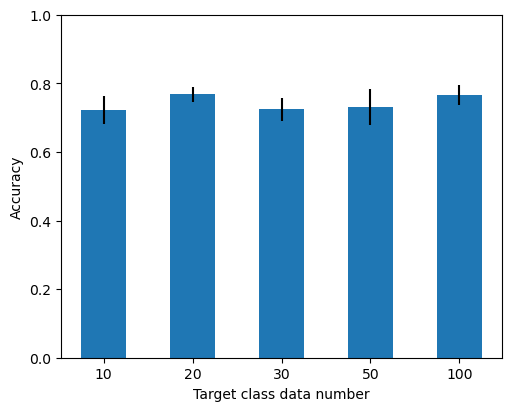

In [113]:
class_name = 4

fig, ax = plt.subplots(layout='constrained', figsize=(5, 4))

sampling_size_list = [10, 20, 30, 50, 100]

width = 0.5  # the width of the bars
multiplier = 1.5
x = np.arange(len(sampling_size_list))

new_acc_list = []
for k in sampling_size_list:
    v = acc_result_dict[(class_name, k)]
    new_acc_list.append(v)

print(new_acc_list)
mean = np.mean(new_acc_list, axis = 1)
std = np.std(new_acc_list, axis = 1)

print(mean, std)

offset = width * multiplier
rects = ax.bar(x + offset, mean, width, label=str(k), align="edge")
ax.errorbar(x + offset + width/2, mean, std, linestyle='None', fmt='-', color="black")
multiplier += 1

ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Target class data number')
ax.set_title(f'')
ax.set_xticks(x + width*2, sampling_size_list)
# ax.legend(loc='upper left', ncols=4, title="Sampling Method")
